# volatility Trading Options Strategy Backtest

This notebook contains a complete, self-contained backtest of a volatility trading strategy. It includes all necessary components:

1.  **Setup**: Installs required libraries.
2.  **Strategy Logic**: The `NewDeltaHedgeStrategy` class.
3.  **Execution & Analysis**: Runs the backtest and displays the results.

## 1. Setup & Configuration

In [ ]:
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

# --- Configuration ---
# You can set your real token here if you replace the mock data source
# os.environ['OPLAB_ACCESS_TOKEN'] = '' 

from opstrat_backtester.core.strategy import Strategy
from opstrat_backtester.core.engine import Backtester
from opstrat_backtester.analytics.plots import plot_pnl
from opstrat_backtester.data_loader import OplabDataSource


## 2. Trading Strategy Definition

In [22]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Tuple

# You would import your base Strategy class from your library
# from opstrat_backtester.core.strategy import Strategy

class ShortStraddleStrategy(Strategy):
    """
    A volatility trading strategy that sells at-the-money (ATM) straddles.

    This strategy aims to profit from high implied volatility (IV) environments
    by selling premium and benefiting from time decay (theta) and/or a drop in IV.
    """
    def __init__(
        self,
        spot_symbol: str,
        entry_iv_hv_ratio: float = 1.5,
        target_dte: int = 45,
        exit_dte: int = 0,
        profit_target_pct: float = 0.50,
        stop_loss_pct: float = 1.00
    ):
        super().__init__()
        self.spot_symbol = spot_symbol
        # --- Strategy Parameters ---
        self.entry_iv_hv_ratio = entry_iv_hv_ratio
        self.target_dte = target_dte
        self.exit_dte = exit_dte
        self.profit_target_pct = profit_target_pct
        self.stop_loss_pct = stop_loss_pct

        # --- State Tracking for Active Trade ---
        self.active_trade_info = {}

    def generate_signals(
        self,
        date: pd.Timestamp,
        daily_options_data: pd.DataFrame,
        stock_history: pd.DataFrame,
        portfolio
    ) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:

        signals = []
        positions = portfolio.get_positions()
        has_option_position = any(ticker != self.spot_symbol for ticker in positions)

        # --- 1. Calculate Volatility Indicators ---
        # Calculate 21-day historical volatility (annualized)
        hv_21d = stock_history['close'].pct_change().rolling(21).std().iloc[-1] * np.sqrt(252)
        
        # Calculate average IV of options near our target DTE
        near_dte_options = daily_options_data[
            daily_options_data['days_to_maturity'].between(self.target_dte - 10, self.target_dte + 10)
        ]
        mean_iv = near_dte_options['volatility'].mean() if not near_dte_options.empty else np.nan

        custom_indicators = {
            'historical_vol_21d': hv_21d,
            'mean_implied_vol': mean_iv,
            'iv_hv_ratio': mean_iv / hv_21d if hv_21d > 0 else np.nan
        }

        # --- 2. Position Management (Exit Logic) ---
        if has_option_position:
            # Get current prices of our held options
            held_tickers = list(self.active_trade_info.get('tickers', []))
            current_position_data = daily_options_data[daily_options_data['symbol'].isin(held_tickers)]

            if len(current_position_data) == 2:
                # A short position's value is negative. We are buying it back, so cost is positive.
                current_cost_to_close = current_position_data['close'].sum() * 100
                initial_premium = self.active_trade_info.get('initial_premium', 0)
                
                pnl = initial_premium - current_cost_to_close
                profit_target = initial_premium * self.profit_target_pct
                stop_loss = -initial_premium * self.stop_loss_pct
                
                current_dte = current_position_data['days_to_maturity'].iloc[0]

                # Check exit conditions
                if pnl >= profit_target or pnl <= stop_loss or current_dte <= self.exit_dte:
                    print(f"INFO [{date.date()}]: Closing straddle. P&L: ${pnl:.2f}, DTE: {current_dte}")
                    for ticker, pos in positions.items():
                        if ticker != self.spot_symbol:
                            signals.append({'ticker': ticker, 'quantity': -pos['quantity']}) # Buy back
                    
                    self.active_trade_info = {} # Reset state after closing

        # --- 3. New Position Entry Logic ---
        elif not has_option_position:
            iv_hv_ratio = custom_indicators.get('iv_hv_ratio', 0)
            
            # Check entry trigger
            if iv_hv_ratio > self.entry_iv_hv_ratio:
                # Find options near our target DTE
                options_for_trade = daily_options_data[
                    daily_options_data['days_to_maturity'].between(self.target_dte - 5, self.target_dte + 5)
                ]
                if not options_for_trade.empty:
                    # Find the at-the-money (ATM) strike
                    spot_price = stock_history['close'].iloc[-1]
                    atm_strike = options_for_trade.iloc[(options_for_trade['strike'] - spot_price).abs().argsort()[:1]]['strike'].iloc[0]
                    
                    # Select the call and put at the ATM strike
                    atm_call = options_for_trade[(options_for_trade['strike'] == atm_strike) & (options_for_trade['type'] == 'CALL')]
                    atm_put = options_for_trade[(options_for_trade['strike'] == atm_strike) & (options_for_trade['type'] == 'PUT')]

                    if not atm_call.empty and not atm_put.empty:
                        call_to_sell = atm_call.iloc[0]
                        put_to_sell = atm_put.iloc[0]

                        print(f"INFO [{date.date()}]: Opening short straddle at strike {atm_strike}.")
                        
                        # Generate signals to sell the straddle (1 contract each)
                        signals.append({'ticker': call_to_sell['symbol'], 'quantity': -1})
                        signals.append({'ticker': put_to_sell['symbol'], 'quantity': -1})

                        # Store trade info for exit management
                        initial_premium_collected = (call_to_sell['close'] + put_to_sell['close']) * 100
                        self.active_trade_info = {
                            'initial_premium': initial_premium_collected,
                            'tickers': [call_to_sell['symbol'], put_to_sell['symbol']]
                        }
        
        return signals, custom_indicators

## 3. Execution and Analysis

In [ ]:
# --- Main Execution Block ---

SPOT_SYMBOL = "BOVA11"
START_DATE = "2023-01-01"
END_DATE = "2024-03-31"
INITIAL_CASH = 100_000.00

# 1. Instantiate the Data Source
oplab_data_source = OplabDataSource()

# 2. Instantiate the Strategy
vol_strategy = ShortStraddleStrategy(
    spot_symbol=SPOT_SYMBOL,
    entry_iv_hv_ratio=1.5,
    target_dte=21,
    exit_dte=5,
    profit_target_pct=0.50,
    stop_loss_pct=1.00
)

# 3. Instantiate and run the Backtester
backtester = Backtester(
    strategy=vol_strategy,
    start_date=START_DATE,
    end_date=END_DATE,
    spot_symbol=SPOT_SYMBOL,
    initial_cash=INITIAL_CASH,
)
backtester.set_data_source(oplab_data_source)

# 4. Run the Backtest
daily_summary_df, trades_df = backtester.run()

print("\n--- Backtest Complete ---")

Starting backtest...
Streaming stock data for BOVA11 from 2023-01-01 00:00:00+00:00 to 2024-03-31 00:00:00+00:00
Processing stock data for year 2023...
Cache miss for stock data stock/BOVA11/2023. Fetching from API...
Cache miss for stock data stock/BOVA11/2023. Fetching from API...
Processing stock data for year 2024...
Cache miss for stock data stock/BOVA11/2024. Fetching from API...
Cache miss for stock data stock/BOVA11/2024. Fetching from API...


/workspaces/optstrat_bt/src/opstrat_backtester/data_loader.py:37: UserWarning: Converting to Period representation will drop timezone information.
  months_to_process = pd.date_range(start=start.to_period('M').start_time.tz_localize('UTC'), end=end, freq='MS')


Streaming data for BOVA11 from 2023-01-01 00:00:00+00:00 to 2024-03-31 00:00:00+00:00


Processing chunk: 2023-01-02 to 2023-01-31



Processing days: 100%|██████████| 21/21 [00:00<00:00, 211.74it/s]


Processing chunk: 2023-02-01 to 2023-02-28


INFO [2023-02-09]: Opening short straddle at strike 104.0.


Processing days: 100%|██████████| 17/17 [00:00<00:00, 177.74it/s]


Processing chunk: 2023-03-01 to 2023-03-31


INFO [2023-03-08]: Closing straddle. P&L: $313.00, DTE: 7
INFO [2023-03-15]: Opening short straddle at strike 99.5.



Processing days: 100%|██████████| 22/22 [00:00<00:00, 139.00it/s]


Processing chunk: 2023-04-03 to 2023-04-28


INFO [2023-04-10]: Closing straddle. P&L: $305.00, DTE: 7
INFO [2023-04-13]: Opening short straddle at strike 103.0.



Processing days: 100%|██████████| 17/17 [00:00<00:00, 151.29it/s]


Processing chunk: 2023-05-02 to 2023-05-31


INFO [2023-05-11]: Closing straddle. P&L: $281.00, DTE: 6
INFO [2023-05-12]: Opening short straddle at strike 105.0.



Processing days: 100%|██████████| 20/20 [00:00<00:00, 143.76it/s]


Processing chunk: 2023-06-02 to 2023-06-30


INFO [2023-06-09]: Closing straddle. P&L: $-376.00, DTE: 5
INFO [2023-06-15]: Opening short straddle at strike 115.0.



Processing days: 100%|██████████| 18/18 [00:00<00:00, 147.22it/s]


Processing chunk: 2023-07-03 to 2023-07-31


INFO [2023-07-12]: Closing straddle. P&L: $284.00, DTE: 7



Processing days: 100%|██████████| 19/19 [00:00<00:00, 120.50it/s]

INFO [2023-07-13]: Opening short straddle at strike 116.0.


Processing chunk: 2023-08-01 to 2023-08-31


INFO [2023-08-11]: Closing straddle. P&L: $279.00, DTE: 5
INFO [2023-08-14]: Opening short straddle at strike 113.0.



Processing days: 100%|██████████| 22/22 [00:00<00:00, 141.62it/s]


Processing chunk: 2023-09-01 to 2023-09-29


INFO [2023-09-06]: Closing straddle. P&L: $271.00, DTE: 7
INFO [2023-09-14]: Opening short straddle at strike 116.0.



Processing days: 100%|██████████| 19/19 [00:00<00:00, 128.81it/s]


Processing chunk: 2023-10-02 to 2023-10-31


INFO [2023-10-13]: Closing straddle. P&L: $126.00, DTE: 5
INFO [2023-10-16]: Opening short straddle at strike 113.0.



Processing days: 100%|██████████| 20/20 [00:00<00:00, 127.31it/s]


Processing chunk: 2023-11-01 to 2023-11-30


INFO [2023-11-10]: Closing straddle. P&L: $19.00, DTE: 5
INFO [2023-11-13]: Opening short straddle at strike 117.0.


Processing days: 100%|██████████| 18/18 [00:00<00:00, 132.14it/s]


Processing chunk: 2023-12-01 to 2023-12-28


INFO [2023-12-08]: Closing straddle. P&L: $-239.00, DTE: 5
INFO [2023-12-14]: Opening short straddle at strike 127.0.



Processing days: 100%|██████████| 18/18 [00:00<00:00, 133.85it/s]


Processing chunk: 2024-01-02 to 2024-01-31


INFO [2024-01-11]: Closing straddle. P&L: $245.00, DTE: 6


INFO [2024-01-12]: Opening short straddle at strike 127.0.


Processing days: 100%|██████████| 21/21 [00:00<00:00, 125.97it/s]


Processing chunk: 2024-02-01 to 2024-02-29


INFO [2024-02-09]: Closing straddle. P&L: $209.00, DTE: 5
INFO [2024-02-14]: Opening short straddle at strike 123.0.



Processing days: 100%|██████████| 17/17 [00:00<00:00, 131.81it/s]


Processing chunk: 2024-03-01 to 2024-03-28


INFO [2024-03-08]: Closing straddle. P&L: $219.00, DTE: 5
INFO [2024-03-11]: Opening short straddle at strike 122.0.



Processing Data Months: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


--- Backtest Complete ---


In [24]:
print("\n--- Daily Portfolio Summary (last 10 days) ---")
daily_summary_df


--- Daily Portfolio Summary (last 10 days) ---


,date,portfolio_value,cash,positions_value,historical_vol_21d,mean_implied_vol,iv_hv_ratio
0,2023-01-02 00:00:00+00:00,100000.00,100000.00,0.00,NaN,37.303766,NaN
1,2023-01-03 00:00:00+00:00,100000.00,100000.00,0.00,NaN,37.099036,NaN
2,2023-01-04 00:00:00+00:00,100000.00,100000.00,0.00,NaN,32.135671,NaN
3,2023-01-05 00:00:00+00:00,100000.00,100000.00,0.00,NaN,28.581043,NaN
4,2023-01-06 00:00:00+00:00,100000.00,100000.00,0.00,NaN,29.348718,NaN
...,...,...,...,...,...,...,...
283,2024-03-21 00:00:00+00:00,99998.65,100001.74,-3.09,0.129499,26.760504,206.646034
284,2024-03-22 00:00:00+00:00,99999.06,100001.74,-2.68,0.132746,27.088135,204.060282
285,2024-03-25 00:00:00+00:00,99999.30,100001.74,-2.44,0.115588,25.583767,221.336709
286,2024-03-26 00:00:00+00:00,99999.03,100001.74,-2.71,0.109083,21.476857,196.885596


In [25]:
print("\n\n--- Detailed Trade Log ---")
# Set display options to see all columns of the detailed log
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.width', 200)
display(trades_df)



--- Detailed Trade Log ---


,decision_date,execution_date,ticker,signal_quantity,decision_symbol,decision_time,decision_spot,decision_type,decision_due_date,decision_strike,decision_premium,decision_maturity_type,decision_days_to_maturity,decision_moneyness,decision_delta,decision_gamma,decision_vega,decision_theta,decision_rho,decision_volatility,decision_poe,decision_bs,decision_open,decision_high,decision_low,decision_close,decision_volume,decision_financial_volume,decision_ewma_current,decision_parent_symbol,decision_spot_price,decision_category,decision_due_date_detail,decision_days_to_maturity_detail,decision_strike_detail,decision_premium_detail,decision_maturity_type_detail,trade_status,execution_price,execution_symbol,execution_time,execution_spot,execution_type,execution_due_date,execution_strike,execution_premium,execution_maturity_type,execution_days_to_maturity,execution_moneyness,execution_delta,execution_gamma,execution_vega,execution_theta,execution_rho,execution_volatility,execution_poe,execution_bs,execution_open,execution_high,execution_low,execution_close,execution_volume,execution_financial_volume,execution_ewma_current,execution_parent_symbol,execution_spot_price,execution_category,execution_due_date_detail,execution_days_to_maturity_detail,execution_strike_detail,execution_premium_detail,execution_maturity_type_detail,historical_vol_21d,mean_implied_vol,iv_hv_ratio
0,2023-02-09 00:00:00+00:00,2023-02-10 00:00:00+00:00,BOVAC82,-1,BOVAC82,2023-02-09 00:00:00+00:00,"{'price': 104.44, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,3.90,AMERICAN,26,ATM,0.546233,0.044212,0.132933,-0.072517,0.054836,26.717,51.21,3.9000,4.90,5.32,3.70,3.90,142100,599498.38,None,BOVA11,104.44,CALL,2023-03-17T00:00:00.000Z,26.0,104.0,3.90,AMERICAN,EXECUTED,3.50,BOVAC82,2023-02-10 00:00:00+00:00,"{'price': 104.75, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,3.76,AMERICAN,25,ATM,0.562055,0.048001,0.130028,-0.069089,0.054678,24.885,53.10,3.7600,3.80,4.06,3.50,3.76,212435,802870.43,None,BOVA11,104.75,CALL,2023-03-17T00:00:00.000Z,25.0,104.0,3.76,AMERICAN,0.207108,27.285039,131.742864
1,2023-02-09 00:00:00+00:00,2023-02-10 00:00:00+00:00,BOVAO82,-1,BOVAO82,2023-02-09 00:00:00+00:00,"{'price': 104.44, 'symbol': 'BOVA11'}",PUT,2023-03-17T00:00:00.000Z,104.0,2.17,EUROPEAN,26,ATM,-0.446305,0.063294,0.132619,-0.043611,-0.050331,18.618,47.00,2.1701,1.53,2.27,1.48,2.17,127458,242199.64,None,BOVA11,104.44,PUT,2023-03-17T00:00:00.000Z,26.0,104.0,2.17,EUROPEAN,EXECUTED,1.95,BOVAO82,2023-02-10 00:00:00+00:00,"{'price': 104.75, 'symbol': 'BOVA11'}",PUT,2023-03-17T00:00:00.000Z,104.0,2.17,EUROPEAN,25,ATM,-0.429736,0.059510,0.129576,-0.048093,-0.046810,20.003,45.46,2.1699,2.31,2.34,1.95,2.17,122765,272260.15,None,BOVA11,104.75,PUT,2023-03-17T00:00:00.000Z,25.0,104.0,2.17,EUROPEAN,0.207108,27.285039,131.742864
2,2023-03-08 00:00:00+00:00,2023-03-09 00:00:00+00:00,BOVAC82,1,BOVAC82,2023-03-08 00:00:00+00:00,"{'price': 103.22, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,1.11,AMERICAN,7,ATM,0.427679,0.108892,0.067501,-0.104402,0.011954,20.945,41.40,1.1100,0.25,1.20,0.25,1.11,788161,701076.64,None,BOVA11,103.22,CALL,2023-03-17T00:00:00.000Z,7.0,104.0,1.11,AMERICAN,EXECUTED,1.10,BOVAC82,2023-03-09 00:00:00+00:00,"{'price': 101.56, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,0.65,AMERICAN,6,OTM,0.277251,0.086503,0.052500,-0.110301,0.006550,24.713,26.46,0.6500,0.96,1.10,0.61,0.65,1104037,874743.45,None,BOVA11,101.56,CALL,2023-03-17T00:00:00.000Z,6.0,104.0,0.65,AMERICAN,0.195374,23.899478,122.326626
3,2023-03-08 00:00:00+00:00,2023-03-09 00:00:00+00:00,BOVAO82,1,BOVAO82,2023-03-08 00:00:00+00:00,"{'price': 103.22, 'symbol': 'BOVA11'}",PUT,2023-03-17T00:00:00.000Z,104.0,1.83,EUROPEAN,7,ATM,-0.572455,0.109057,0.067497,-0.095986,-0.016922,20.912,58.61,1.8301,3.00,3.00,1.70,1.83,784943,1536250.10,None,BOVA11,103.22,PUT,2023-03-17T00:00:00.000Z,7.0,104.0,1.83,EUROPEAN,EXECUTED,2.62,BOVAO82,2023-03-09 00:00:00+00:00,"{'price': 101.56, 'symbol'

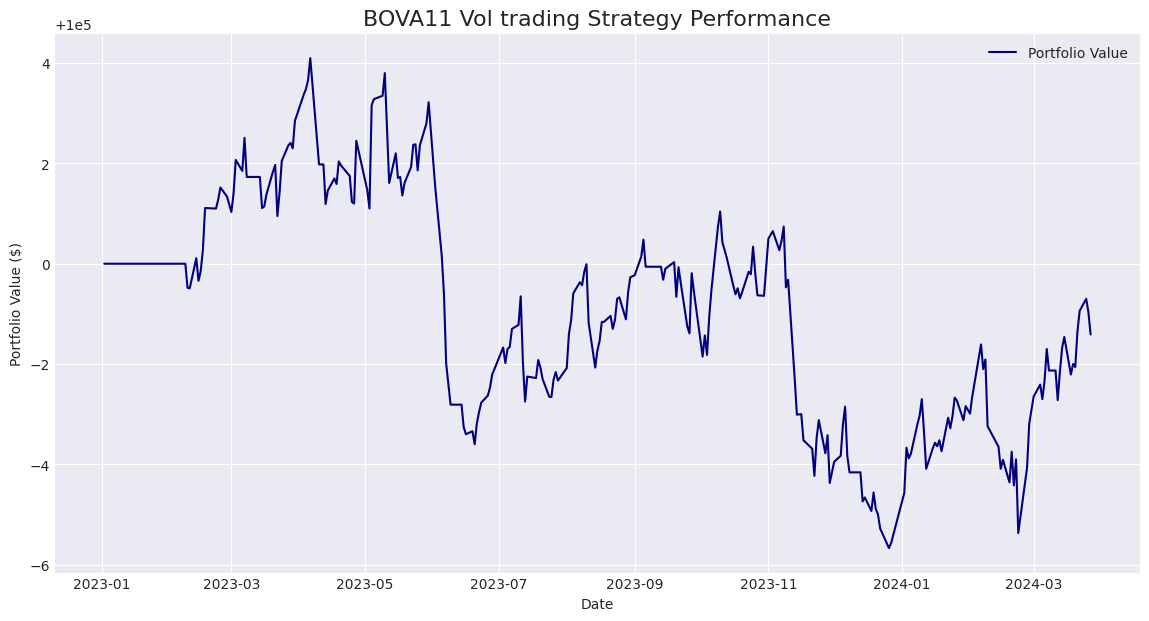

In [26]:
def plot_pnl(daily_summary: pd.DataFrame, title: str):
    """Plots the portfolio value over time."""
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Ensure the date column is a datetime object for plotting
    daily_summary['date'] = pd.to_datetime(daily_summary['date'])
    
    ax.plot(daily_summary['date'], daily_summary['portfolio_value'], label='Portfolio Value', color='navy')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value ($)')
    ax.legend()
    plt.grid(True)
    plt.show()

plot_pnl(daily_summary_df, title=f"{SPOT_SYMBOL} Vol trading Strategy Performance")